In [77]:
import spacy

nlp = spacy.load("nl_core_news_lg")
from util.conferences import get_conference_data, correct_cwd, get_sentences
from util.infections import get_infection_data
import datetime as dt


In [78]:
correct_cwd()

In [79]:
def tokenize_texts(texts):
    processed_texts = [text for text in nlp.pipe(texts, disable=["ner", "parser"])]
    tokenized_texts_sw = []
    for processed_text in processed_texts:
        tokenized_text_sw = [word.text.lower() for word in processed_text if not word.is_stop]
        tokenized_texts_sw.append(tokenized_text_sw)
    return tokenized_texts_sw

In [80]:
rutte_data, de_jonge_data = get_conference_data(include_journalist_questions=True)
rutte_texts = [content['text'] for content in rutte_data]
de_jonge_texts = [content['text'] for content in de_jonge_data]

In [81]:
rutte_sentences = [get_sentences(rutte_text) for rutte_text in rutte_texts]
date_strings = [content['date'] for content in rutte_data]
dates = [dt.datetime.strptime(date, '%Y-%m-%d').date() for date in date_strings]
de_jonge_sentences = [get_sentences(de_jonge_text) for de_jonge_text in de_jonge_texts]

In [82]:
def stam_ww(token_tags):
    required_tags = ['WW', 'ev', 'tgw']
    return all([required_position in token_tags for required_position in required_tags])

In [83]:
def has_imperative_form(sentence: str):
    doc = nlp(sentence)
    subjects = [tok.dep_ for tok in doc if (tok.dep_ == 'nsubj')]
    verbs = [tok for tok in doc if stam_ww(tok.tag_)]

    if not subjects and doc[0] in verbs and not '?' in sentence:
        return sentence

In [84]:
from tqdm.notebook import tqdm

relative_proportions = []

for rut, dejonge in tqdm(zip(rutte_sentences, de_jonge_sentences)):
    count = 0
    for sentence in rut + dejonge:
        if has_imperative_form(sentence):
            count += 1
            print(sentence)
    relative_proportions.append(count / (len(rut) + len(dejonge)))

0it [00:00, ?it/s]

Doe dit, maak hier gebruik van deze aanwijzingen: handen wassen, in je elleboog niezen en gebruik maken van papieren zakdoekjes.
Wacht, even, uw vraag te beantwoorden.
Kijk naar bijvoorbeeld China.
Is er ook nog geen vaccin ontwikkeld.
Kijk, prik mij niet op die drie maanden.
Blijf even in een nette rij staan, maar wel anderhalve meter uit elkaar.
Denk aan het niet kunnen bezoeken van opa of oma in het verpleeghuis op dit moment.
Wees aardig en begripvol voor elkaar.
Denk in Europa bijvoorbeeld om Oostenrijk, Italië en Spanje, maar ook landen buiten Europa zoals Iran, Zuid-Korea en China.
Ga niet met zijn allen naar de gebruikelijke hotspots toe.
Denk aan de stranden, de recreatiegebieden en dergelijke.
Is niet mijn waarneming.
Doe het niet.
Blijf thuis, bleib zu Hause, rester à la maison.
Hou dus alsjeblieft vol.
Kan ook via Bluetooth.
Zeg mij allemaal helemaal niks, nee hoor.
Maak van die boodschappen geen uitje met kinderen en vrouw of man.
Stel, kijk er wordt ontzettend hard gewerk

In [90]:
# from https://matplotlib.org/devdocs/gallery/subplots_axes_and_figures/two_scales.html
def two_lines(t1, data1, t2, data2):
    fig, ax1 = plt.subplots()

    color = 'tab:red'
    ax1.set_xlabel('date')
    ax1.set_ylabel('imperative usage', color=color)
    ax1.plot(t1, data1, color=color)
    ax1.tick_params(axis='y', labelcolor=color)

    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

    color = 'tab:blue'
    ax2.set_ylabel('new infections per day MA', color=color)  # we already handled the x-label with ax1
    ax2.plot(t2, data2, color=color)
    ax2.tick_params(axis='y', labelcolor=color)

    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    plt.rcParams["figure.figsize"] = (20, 10)
    plt.savefig('output/imperative_usage-infections.png')
    plt.show()

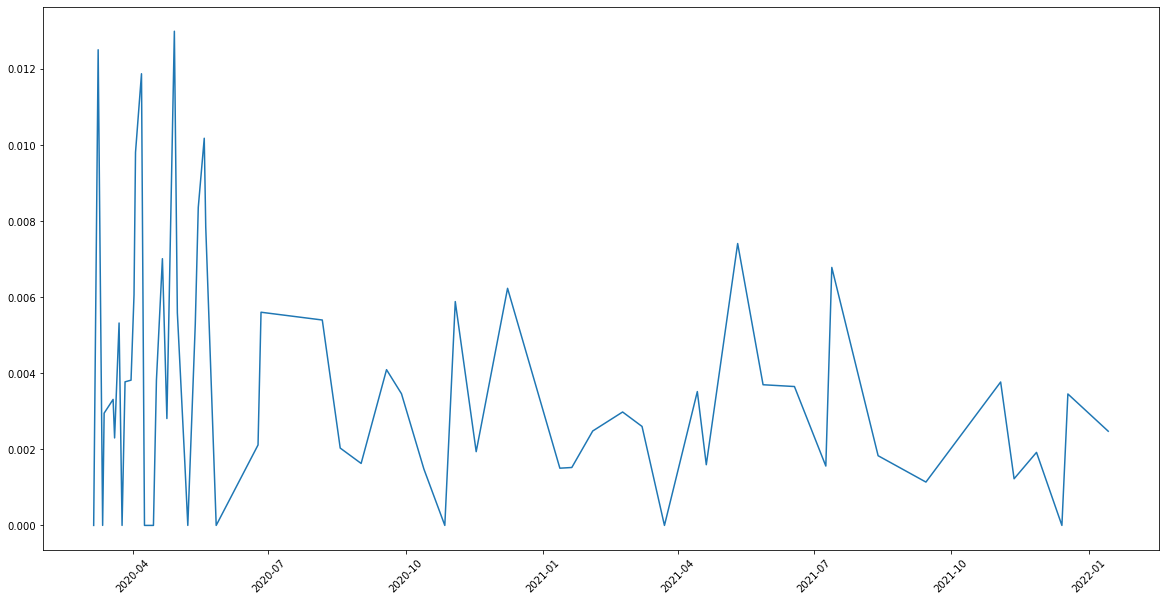

In [93]:
import matplotlib.pyplot as plt

x = dates
y = relative_proportions
plt.plot(x,  y)
plt.xticks(rotation=45)
plt.show()

In [87]:
infections = get_infection_data()
infections['new_infection_ma'] = infections['new_infections'].rolling(window=4).mean()
infections

,date,total_infections,new_infections,new_infection_ma
0,2020-03-13,804,804,NaN
1,2020-03-14,959,155,NaN
2,2020-03-15,1135,176,NaN
3,2020-03-16,1413,278,353.25
4,2020-03-17,1705,292,225.25
...,...,...,...,...
679,2022-01-21,3778287,57471,41734.00
680,2022-01-22,3824344,46057,45412.00
681,2022-01-23,3889669,65325,52193.25
682,2022-01-24,3954299,64630,58370.75


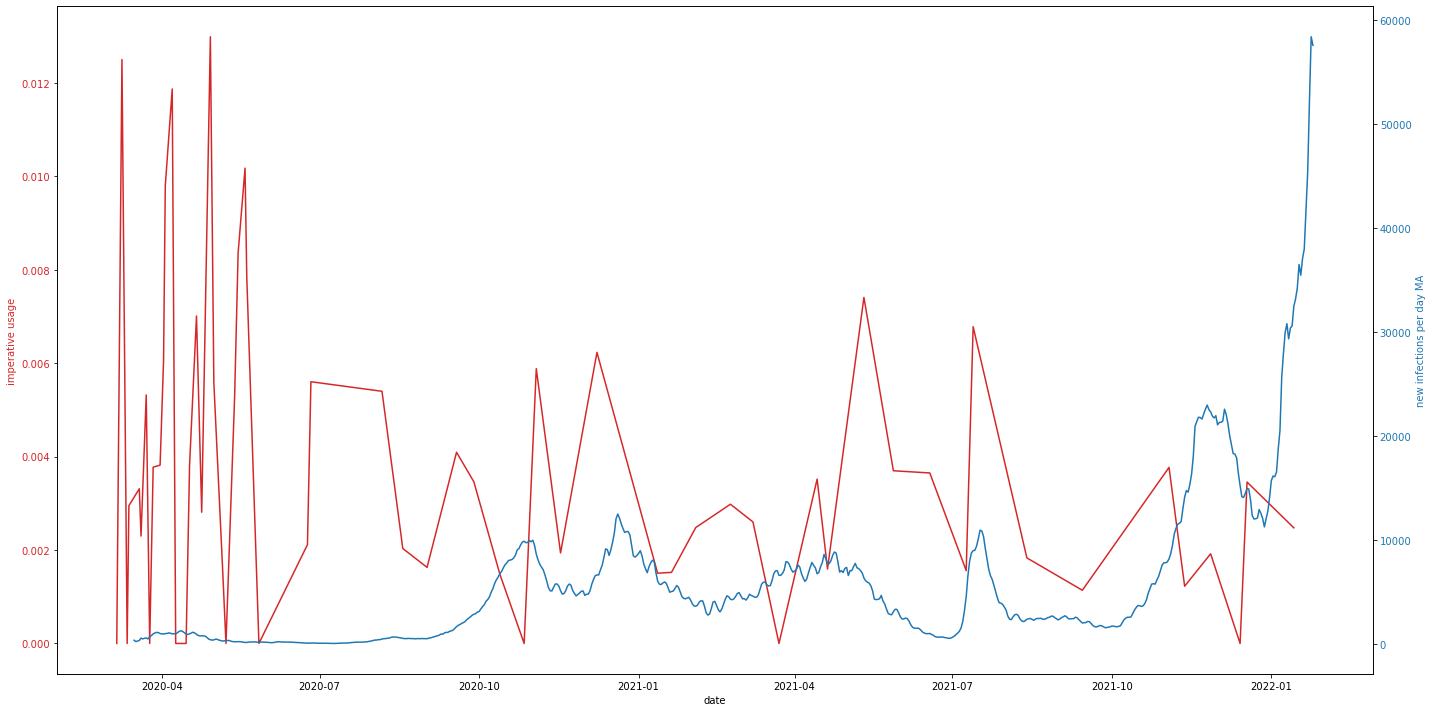

In [88]:
x2 = [dt.datetime.strptime(date, '%Y-%m-%d').date() for date in infections.date]
y2 = infections.new_infection_ma
two_lines(x, y, x2, y2)